In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### load packages

In [4]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [6]:
dataset = 'cassins'
dims = (32,32,1)
n_components = 64

In [7]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

syllable_df = pd.read_pickle(DATA_DIR/'cassins'/ 'cassins.pickle')



top_labels = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.labels.values == i)] for i in syllable_df.labels.unique()}
    )
    .T.sort_values(by=0, ascending=False)[:20]
    .T
)

syllable_df = syllable_df[syllable_df.labels.isin(top_labels.columns)]

syllable_df[:3]
syllable_df = syllable_df.reset_index()

syllable_df['subset'] = 'train'
syllable_df.loc[:1000, 'subset'] = 'valid'
syllable_df.loc[1000:1999, 'subset'] = 'test'

specs = np.array(list(syllable_df.spectrogram.values))
specs = np.array([np.concatenate([np.zeros((32,1)), i], axis=1) for i in tqdm(specs)])


syllable_df['spectrogram'] = syllable_df['spectrogram'].astype('object')
syllable_df['spectrogram'] = list(specs)


Y_train = np.array(list(syllable_df.labels.values[syllable_df.subset == 'train']))
Y_valid = np.array(list(syllable_df.labels.values[syllable_df.subset == 'valid']))
Y_test = np.array(list(syllable_df.labels.values[syllable_df.subset == 'test']))

X_train = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'train'])) #/ 255.
X_valid = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'valid']))# / 255.
X_test = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'test'])) #/ 255.

X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
Y_train = enc.fit_transform([[i] for i in Y_train]).astype('int').flatten()
Y_test = enc.fit_transform([[i] for i in Y_test]).astype('int').flatten()
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

### define networks

In [8]:
from tensorflow.keras.layers import (
    Conv2D,
    Reshape,
    Bidirectional,
    Dense,
    RepeatVector,
    TimeDistributed,
    LSTM
)

In [9]:
from tfumap.vae import VAE, Sampling

In [10]:

encoder_inputs = tf.keras.Input(shape=dims)
x = Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu, padding="same"
    )(encoder_inputs)
x = Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu, padding="same"
    )(x)
x = Conv2D(
        filters=128, kernel_size=3, strides=(2, 1), activation=tf.nn.leaky_relu, padding="same"
    )(x)
x = Conv2D(
        filters=128, kernel_size=3, strides=(2, 1), activation=tf.nn.leaky_relu, padding="same"
    )(x)
x = Reshape(target_shape=(8, 2*128))(x)
x = Bidirectional(LSTM(units=100, activation="relu"))(x)
x = Dense(units=512)(x)
z_mean = tf.keras.layers.Dense(n_components, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(n_components, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

W0822 10:08:37.774958 140156596483904 recurrent_v2.py:1098] Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
W0822 10:08:37.779890 140156596483904 recurrent_v2.py:1098] Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
W0822 10:08:37.785395 140156596483904 recurrent_v2.py:1098] Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 4, 8, 128)    73856       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [11]:
latent_inputs = tf.keras.Input(shape=(n_components,))
x = Dense(units=512)(latent_inputs)
x = RepeatVector(8)(x)
x = Bidirectional(LSTM(units=100, activation="relu", return_sequences=True))(x)
x = TimeDistributed(Dense(2*128))(x)
x = Reshape(target_shape=(8,2,128))(x)
x = tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(1, 2), padding="SAME", activation=tf.nn.leaky_relu
    )(x)

x = tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(1, 2), padding="SAME", activation=tf.nn.leaky_relu
    )(x)
x = tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    )(x)
x = tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    )(x)
x = tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    )(x)


decoder_outputs = Reshape(target_shape=(32, 32, 1))(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


W0822 10:08:38.014850 140156596483904 recurrent_v2.py:1098] Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
W0822 10:08:38.024241 140156596483904 recurrent_v2.py:1098] Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
W0822 10:08:38.028821 140156596483904 recurrent_v2.py:1098] Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               33280     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 8, 512)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 8, 200)            490400    
_________________________________________________________________
time_distributed (TimeDistri (None, 8, 256)            51456     
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 2, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 4, 128)         1475

### Create model and train

In [12]:
X_train.shape

(24984, 32, 32)

In [13]:
X_train = X_train.reshape([len(X_train)]+ list(dims))
X_train.shape

(24984, 32, 32, 1)

In [14]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

In [15]:
vae.fit(X_train, epochs=30, batch_size=128)

Epoch 1/30
196/196 [==============================] - 10s 52ms/step - loss: 124.5450 - reconstruction_loss: 124.2098 - kl_loss: 0.3352
Epoch 2/30
196/196 [==============================] - 10s 53ms/step - loss: 93.4402 - reconstruction_loss: 92.6499 - kl_loss: 0.7904
Epoch 3/30
196/196 [==============================] - 10s 52ms/step - loss: 86.4320 - reconstruction_loss: 85.5443 - kl_loss: 0.8877
Epoch 4/30
196/196 [==============================] - 10s 53ms/step - loss: 82.4218 - reconstruction_loss: 81.5636 - kl_loss: 0.8582
Epoch 5/30
196/196 [==============================] - 10s 53ms/step - loss: 80.5862 - reconstruction_loss: 79.7849 - kl_loss: 0.8014
Epoch 6/30
196/196 [==============================] - 10s 52ms/step - loss: 79.6182 - reconstruction_loss: 78.8903 - kl_loss: 0.7279
Epoch 7/30
196/196 [==============================] - 10s 52ms/step - loss: 79.0273 - reconstruction_loss: 78.3469 - kl_loss: 0.6804
Epoch 8/30
196/196 [==============================] - 10s 50ms/step

In [16]:
z = vae.encoder.predict(X_train)[0]

### Plot model output

In [17]:
Y_train

array([14, 11, 11, ...,  6,  0,  0])

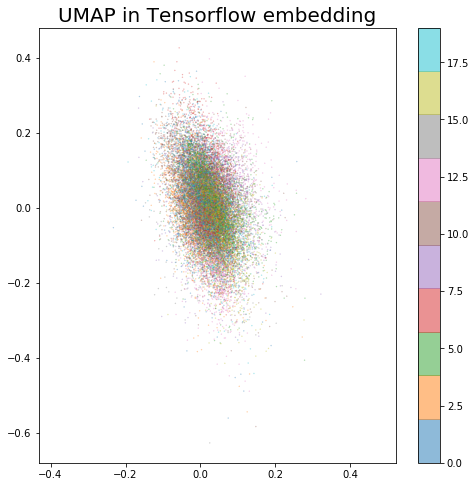

In [18]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)].flatten(),
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [19]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

### Save output

In [20]:
dataset = "cassins_dtw"

In [21]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [22]:
output_dir = MODEL_DIR/'projections'/ dataset /  '64'/ 'vae'
ensure_dir(output_dir)

In [23]:
#vae.save(output_dir)

In [24]:
vae.encoder.save(output_dir / 'encoder')

W0822 10:13:49.997952 140156596483904 deprecation.py:323] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
W0822 10:13:50.012688 140156596483904 deprecation.py:323] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Layer.updates (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
I0822 10:13:52.162152 140156596483904 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cassins_dtw/6

In [25]:
vae.decoder.save(output_dir / 'encoder')

I0822 10:13:56.333064 140156596483904 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cassins_dtw/64/vae/encoder/assets


In [26]:
#loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [27]:
np.save(output_dir / 'z.npy', z)

### compute metrics 

In [28]:
X_test.shape

(1000, 32, 32)

In [29]:
z_test = encoder.predict(X_test.reshape((len(X_test), 32,32,1)))[0]

#### silhouette

In [30]:
from tfumap.silhouette import silhouette_score_block

In [31]:
ss, sil_samp = silhouette_score_block(z, Y_train, n_jobs = -1)
ss

0.15833879286782773

In [32]:
ss_test, sil_samp_test = silhouette_score_block(z_test, Y_test, n_jobs = -1)
ss_test

0.22506680453932565

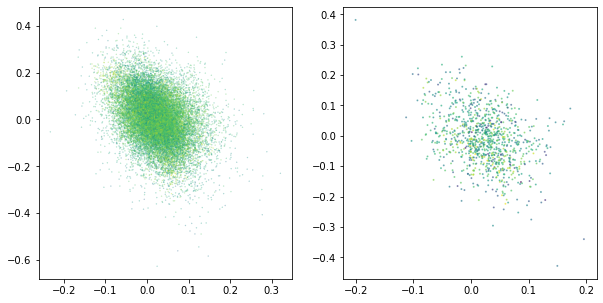

In [33]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=sil_samp, cmap=plt.cm.viridis)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=sil_samp_test, cmap=plt.cm.viridis)

#### KNN

In [34]:
from sklearn.neighbors import KNeighborsClassifier

In [35]:
z

array([[-0.04244103,  0.05020817,  0.03919956, ...,  1.2407975 ,
         0.03620336,  0.04856126],
       [ 0.09443478, -0.11061835, -0.05397689, ..., -0.2163135 ,
         0.00457929, -0.3634016 ],
       [ 0.02341519,  0.0124176 ,  0.01211085, ..., -0.07058898,
         0.0259145 , -0.18067323],
       ...,
       [ 0.0919086 ,  0.02771177, -0.03741535, ..., -0.1334303 ,
        -0.1217416 ,  0.14443208],
       [ 0.02607518, -0.01759579,  0.01393413, ...,  0.70366824,
        -0.01251261,  0.00551696],
       [-0.00598954, -0.09738456, -0.01983831, ...,  0.98287433,
        -0.0150048 , -0.08635031]], dtype=float32)

In [36]:
z_test

array([[-1.5856870e-02, -1.1571610e-01,  1.0721872e-03, ...,
        -5.4440320e-01, -4.1967232e-02, -6.3511394e-03],
       [-4.5025375e-02, -1.1397982e-01, -5.6286372e-02, ...,
        -1.3217559e-01,  4.8730027e-02, -1.3319965e-02],
       [ 2.8760530e-02,  2.0176802e-02,  7.4132442e-02, ...,
        -8.9482534e-01,  6.1956700e-02,  1.2178561e-01],
       ...,
       [ 7.5081579e-02,  5.9062157e-02, -2.2164993e-02, ...,
        -1.6333728e-01, -1.0236453e-02,  9.4093382e-02],
       [-3.8045570e-03, -2.6824441e-02,  4.3822143e-02, ...,
         6.8491012e-01,  1.6883630e-02, -3.0810192e-02],
       [ 9.6976347e-02, -2.1178933e-02, -3.1293940e-02, ...,
        -1.2630982e+00, -2.6226986e-02, -4.5030657e-02]], dtype=float32)

In [37]:
Y_train

array([14, 11, 11, ...,  6,  0,  0])

In [38]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(z, Y_train)
score_5nn = neigh5.score(z_test, Y_test)
score_5nn

0.988

In [39]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(z, Y_train)
score_1nn = neigh1.score(z_test, Y_test)
score_1nn

0.98

#### Trustworthiness

In [40]:
from sklearn.manifold import trustworthiness

In [41]:
tw = trustworthiness(X_train_flat[:10000], z[:10000])

In [42]:
tw_test = trustworthiness(X_test_flat[:10000], z_test[:10000])

In [43]:
tw, tw_test

(0.9948842894315453, 0.990220564516129)

### Save output metrics

In [44]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

#### train

In [45]:
metrics_df = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df.loc[len(metrics_df)] = [dataset, 'vae', n_components, tw, ss, sil_samp]
metrics_df

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
0,cassins_dtw,vae,64,0.994884,0.158339,"[0.31641692934195603, 0.11196094985030139, 0.1..."


In [46]:
save_loc = DATA_DIR / 'projection_metrics' /  'vae' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)
save_loc

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/data/projection_metrics/vae/train/64/cassins_dtw.pickle')

#### test

In [47]:
metrics_df_test = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df_test.loc[len(metrics_df)] = [dataset, 'vae', n_components, tw_test, ss_test, sil_samp_test]
metrics_df_test

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
1,cassins_dtw,vae,64,0.990221,0.225067,"[0.20978888806866355, 0.31581369453809977, 0.3..."


In [48]:
save_loc = DATA_DIR / 'projection_metrics' / 'vae' / 'test' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### knn 

In [49]:
nn_acc_df = pd.DataFrame(columns = ["method_","dimensions","dataset","1NN_acc","5NN_acc"])
nn_acc_df.loc[len(nn_acc_df)] = ['vae', n_components, dataset,  score_1nn, score_5nn]
nn_acc_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,vae,64,cassins_dtw,0.98,0.988


In [50]:
save_loc = DATA_DIR / 'knn_classifier' / 'vae' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
nn_acc_df.to_pickle(save_loc)

### Reconstruction

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

In [52]:
X_recon = vae.decoder.predict(vae.encoder.predict(X_test.reshape((len(X_test), 32, 32, 1)))[0])
X_real = X_test.reshape((len(X_test), 32, 32, 1))

In [53]:
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

In [54]:
reconstruction_acc_df = pd.DataFrame(
    columns=["method_", "dimensions", "dataset", "MSE", "MAE", "MedAE", "R2"]
)

In [55]:
MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['vae', 64, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,vae,64,cassins_dtw,0.001331,0.012782,0.006875,-9389.089214


In [56]:
save_loc = DATA_DIR / 'reconstruction_acc' / 'vae' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
reconstruction_acc_df.to_pickle(save_loc)

### Compute clustering quality

In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure

In [58]:
def get_cluster_metrics(row, n_init=5):
    
    # load cluster information
    save_loc = DATA_DIR / 'clustering_metric_df'/ ('_'.join([row.class_, str(row.dim), row.dataset]) + '.pickle')
    print(save_loc)
    #if save_loc.exists() and save_loc.is_file():
    #    
    #    cluster_df = pd.read_pickle(save_loc)
    #    return cluster_df
    
    # make cluster metric dataframe
    cluster_df = pd.DataFrame(
        columns=[
            "dataset",
            "class_",
            "dim",
            "silhouette",
            "homogeneity",
            "completeness",
            "v_measure",
            "init_",
            "n_clusters",
            "model",
        ]
    )
    y = row.train_label
    z = row.train_z
    n_labels = len(np.unique(y))
    for n_clusters in tqdm(np.arange(n_labels - int(n_labels / 2), n_labels + int(n_labels / 2)), leave=False, desc = 'n_clusters'):
        for init_ in tqdm(range(n_init), leave=False, desc='init'):
            kmeans = KMeans(n_clusters=n_clusters, random_state=init_).fit(z)
            clustered_y = kmeans.labels_
            homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(
                y, clustered_y
            )
            ss, _ = silhouette_score_block(z, clustered_y)
            cluster_df.loc[len(cluster_df)] = [
                row.dataset,
                row.class_,
                row.dim,
                ss,
                homogeneity,
                completeness,
                v_measure,
                init_,
                n_clusters,
                kmeans,
            ]
    
     # save cluster df in case this fails somewhere
    ensure_dir(save_loc)
    cluster_df.to_pickle(save_loc)
    return cluster_df

In [59]:
projection_df = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label', 'dim'])
projection_df.loc[len(projection_df)] = [dataset, 'vae', z, Y_train.flatten(), n_components]
projection_df

,dataset,class_,train_z,train_label,dim
0,cassins_dtw,vae,"[[-0.042441033, 0.05020817, 0.039199565, 0.040...","[14, 11, 11, 11, 11, 11, 11, 11, 11, 17, 0, 0,...",64


In [60]:
get_cluster_metrics(projection_df.iloc[0], n_init=5)

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/data/clustering_metric_df/vae_64_cassins_dtw.pickle


,dataset,class_,dim,silhouette,homogeneity,completeness,v_measure,init_,n_clusters,model
0,cassins_dtw,vae,64,0.253794,0.588147,0.782382,0.671501,0,10,"KMeans(n_clusters=10, random_state=0)"
1,cassins_dtw,vae,64,0.253795,0.588208,0.782454,0.671567,1,10,"KMeans(n_clusters=10, random_state=1)"
2,cassins_dtw,vae,64,0.253761,0.588159,0.782343,0.671494,2,10,"KMeans(n_clusters=10, random_state=2)"
3,cassins_dtw,vae,64,0.253794,0.588129,0.782357,0.671479,3,10,"KMeans(n_clusters=10, random_state=3)"
4,cassins_dtw,vae,64,0.253794,0.588129,0.782357,0.671479,4,10,"KMeans(n_clusters=10, random_state=4)"
...,...,...,...,...,...,...,...,...,...,...
95,cassins_dtw,vae,64,0.286230,0.836382,0.749434,0.790524,0,29,"KMeans(n_clusters=29, random_state=0)"
96,cassins_dtw,vae,64,0.294373,0.838084,0.754878,0.794308,1,29,"KMeans(n_clusters=29, random_state=1)"
97,cassins_dtw,vae,64,0.287079,0.840021,0.753849,0.794606,2,29,"KMeans(n_clusters=29, random_state=2)"
98,cassins_dtw,vae,64,0.305724,0.838055,0.759943,0.797090,3,29,"KMeans(n_clusters=29, random_state=3)"
